In [1]:
import warnings;
warnings.simplefilter('ignore')
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import  seasonal_decompose
import plotly.express as px
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import datetime as dt
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
plt.style.use('seaborn')
%matplotlib inline


Adatok betöltése, átalakítása, index beállítása

In [2]:
df = pd.read_csv("Rainfall_1901_2016_PAK.csv",sep=',')

In [3]:
df

,Rainfall - (MM),Year,Month
0,40.42580,1901,January
1,12.30220,1901,February
2,25.51190,1901,March
3,14.29420,1901,April
4,38.30460,1901,May
...,...,...,...
1387,60.60610,2016,August
1388,13.76940,2016,September
1389,1.07552,2016,October
1390,2.88480,2016,November


In [4]:
df.index = pd.Index(sm.tsa.datetools.dates_from_range('1901m1', '2016m12'))
df = df.rename(columns = {'Rainfall - (MM)':'Rainfall',' Year':'Year'})
df.head()
df = df.drop(columns=['Year','Month'])

In [5]:
df.head()

,Rainfall
1901-01-31,40.4258
1901-02-28,12.3022
1901-03-31,25.5119
1901-04-30,14.2942
1901-05-31,38.3046


In [35]:
df.drop_duplicates(inplace=True)

In [38]:
df.isnull().sum()

Rainfall              0
4-month-SMA           3
8-month-SMA           7
12-month-SMA         11
EWMA12                0
TESadd12              0
ARIMA_Predictions     0
dtype: int64

Adatok ploton ábrázolása

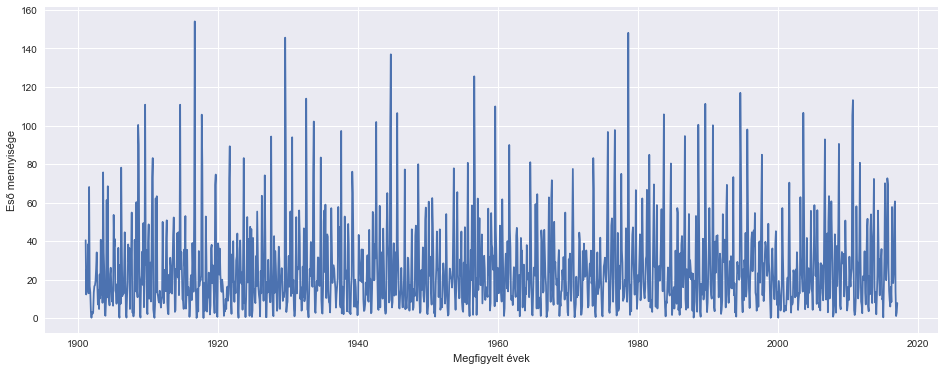

In [6]:
plt.figure(figsize=(16,6))
plt.plot(df['Rainfall'])
plt.xlabel('Megfigyelt évek')
plt.ylabel('Eső mennyisége')
plt.show()

4-8-12 hónapos mozgóátlag illesztése az eredeti adatra

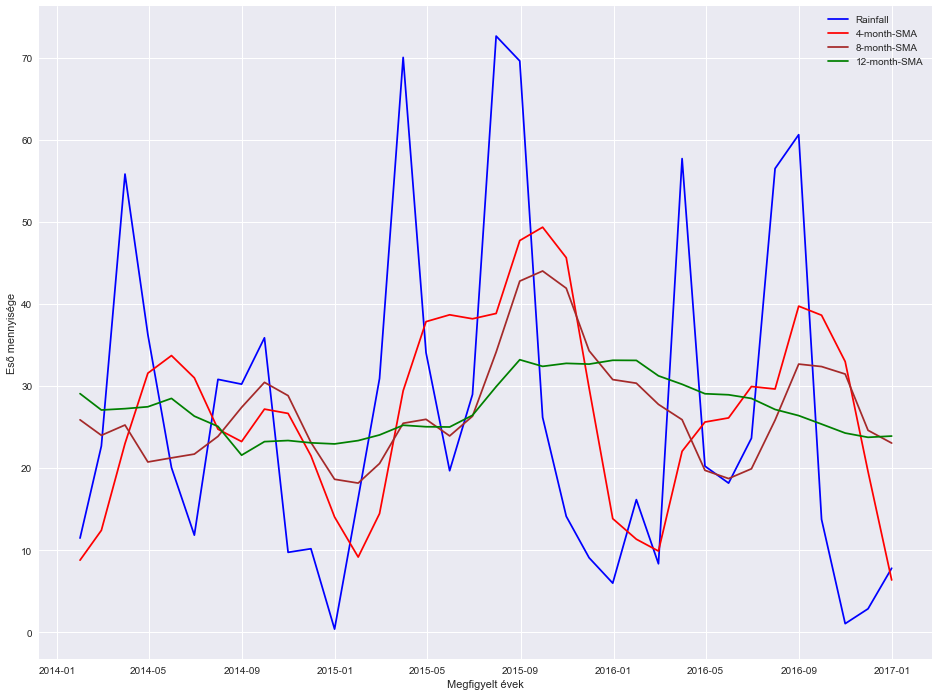

In [8]:
plt.figure(figsize=(16,12))
df['4-month-SMA']=df['Rainfall'].rolling(window=4).mean()
df['8-month-SMA']=df['Rainfall'].rolling(window=8).mean()
df['12-month-SMA']=df['Rainfall'].rolling(window=12).mean()

plt.plot(df['Rainfall'][-36:],color='blue')
plt.plot(df['4-month-SMA'][-36:],color='red')
plt.plot(df['8-month-SMA'][-36:],color='brown')
plt.plot(df['12-month-SMA'][-36:],color='green')
plt.xlabel('Megfigyelt évek')
plt.ylabel('Eső mennyisége')
plt.legend(["Rainfall","4-month-SMA","8-month-SMA","12-month-SMA"])
plt.show()

In [30]:
df

,Rainfall,4-month-SMA,8-month-SMA,12-month-SMA,EWMA12,TESadd12,ARIMA_Predictions
1901-01-31,40.42580,NaN,NaN,NaN,40.425800,40.435800,25.145202
1901-02-28,12.30220,NaN,NaN,NaN,36.099092,12.321646,29.105791
1901-03-31,25.51190,NaN,NaN,NaN,34.470293,25.540241,18.070489
1901-04-30,14.29420,23.133525,NaN,NaN,31.366279,14.330889,24.632126
1901-05-31,38.30460,22.603225,NaN,NaN,32.433713,38.349097,23.684413
...,...,...,...,...,...,...,...
2016-08-31,60.60610,39.731325,32.676395,26.404177,34.684299,61.518252,44.954266
2016-09-30,13.76940,38.627275,32.375707,25.368811,31.466622,28.207665,33.442438
2016-10-31,1.07552,32.983205,31.464602,24.279946,26.791068,8.895173,10.743291
2016-11-30,2.88480,19.583955,24.613352,23.762345,23.113181,8.112977,7.420782


## Látható, hogy minél magasabb mozgóátlagot adunk meg, annál kisebb lesz a változása az eső mennyiségének

# Exponential Smoothing

In [8]:
#Exponenciálisan súlyozott mozgóátlag
df['EWMA12'] = df['Rainfall'].ewm(span=12,adjust=False).mean()

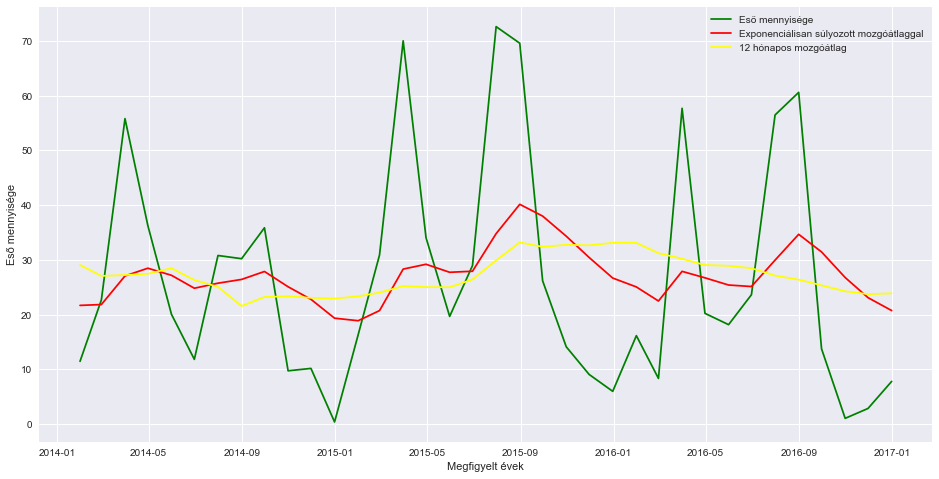

In [29]:
#Összehasonlíthatjuk a 12 hónapos mozgóátlaggal is
plt.figure(figsize=(16,8))
plt.plot(df['Rainfall'][-36:],color='green')
plt.plot(df['EWMA12'][-36:],color='red')
plt.plot(df['12-month-SMA'][-36:],color='yellow')
plt.xlabel('Megfigyelt évek')
plt.ylabel('Eső mennyisége')
plt.legend(['Eső mennyisége','Exponenciálisan súlyozott mozgóátlaggal','12 hónapos mozgóátlag'])
plt.show()

##  Háromszoros exponenciális símítást csinálunk

In [10]:
df['TESadd12'] = ExponentialSmoothing(df['Rainfall'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
df.head()

C:\Users\martinturcsanyi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\martinturcsanyi\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


,Rainfall,4-month-SMA,8-month-SMA,12-month-SMA,EWMA12,TESadd12
1901-01-31,40.4258,NaN,NaN,NaN,40.425800,40.435800
1901-02-28,12.3022,NaN,NaN,NaN,36.099092,12.321646
1901-03-31,25.5119,NaN,NaN,NaN,34.470293,25.540241
1901-04-30,14.2942,23.133525,NaN,NaN,31.366279,14.330889
1901-05-31,38.3046,22.603225,NaN,NaN,32.433713,38.349097


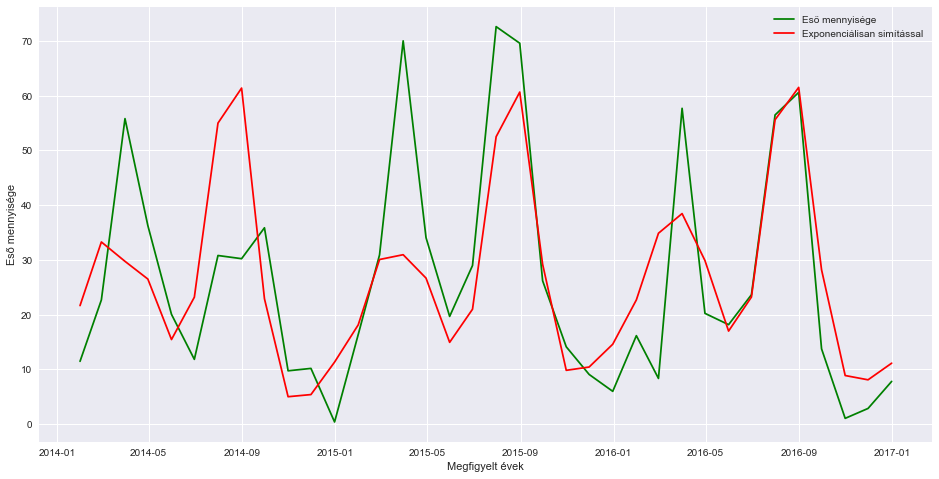

In [14]:
plt.figure(figsize=(16,8))
plt.plot(df['Rainfall'][-36:],color='green')
plt.plot(df['TESadd12'][-36:],color='red')
plt.xlabel('Megfigyelt évek')
plt.ylabel('Eső mennyisége')
plt.legend(['Eső mennyisége','Exponenciálisan simítással'])
plt.show()

Látható, hogy a kiugró értékek csökkentek exponenciális simítással

## Seasonal decomposal megnézzünk, hogy követ-e valamilyen trendet, illetve, hogy van e szezonalitás

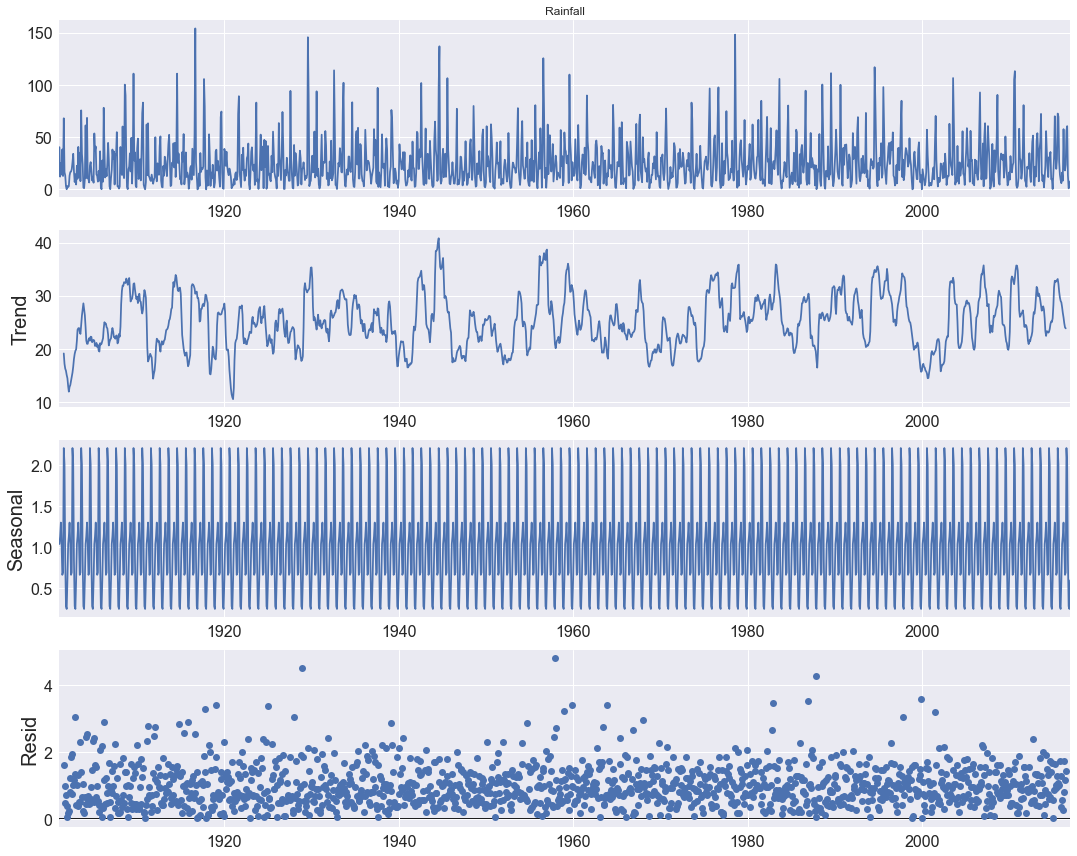

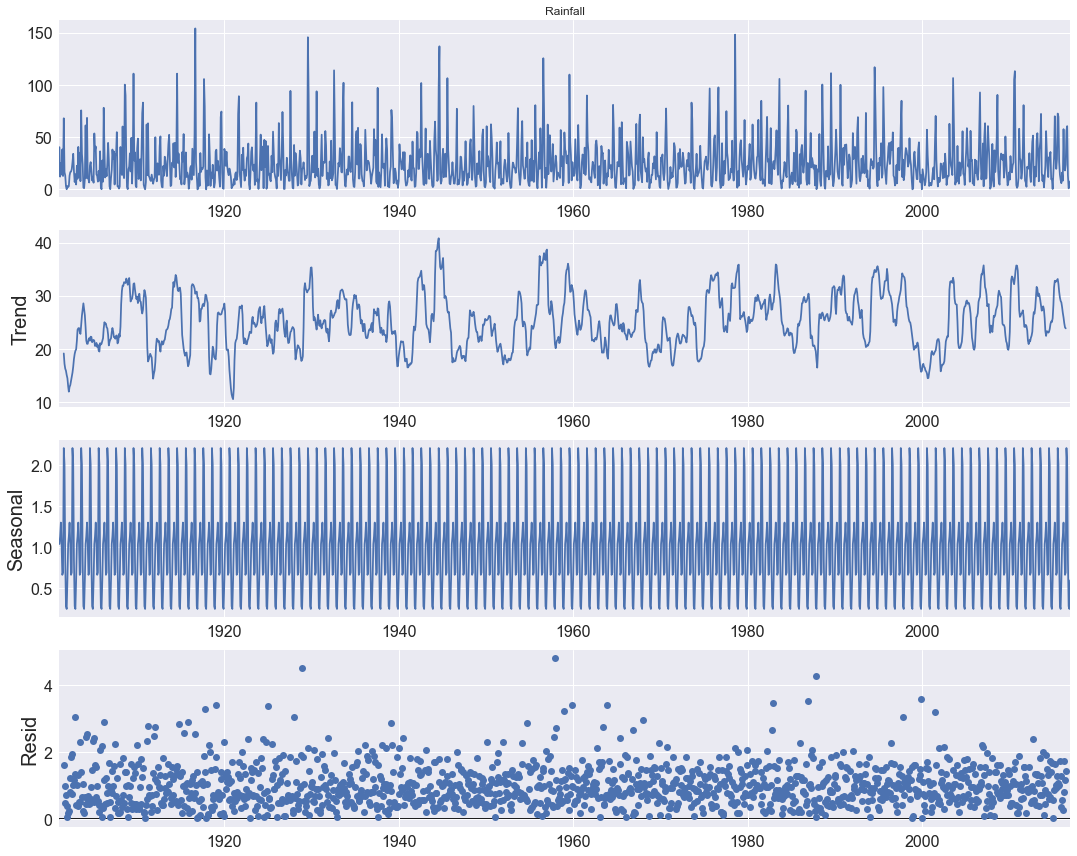

In [11]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 12
rcParams['axes.labelsize'] = 20
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
result = seasonal_decompose(df['Rainfall'], model='multiplicative').plot()
result

### Látható, hogy nem követ semmilyen trendet az ábra, ezért már itt is kijelenthetnénk, hogy stacionárius, de azért nézzünk meg egy adfuller tesztet.
### A szezonalitás becsapós mivel rengeteg év van ábrázolva, ezért összefolyik.

In [12]:
import pmdarima as pmd

In [13]:
result = adfuller(df['Rainfall'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -6.695889008362768
p-value: 4.000735413148214e-09
Critical Values:
	1%: -3.435139190725917
	5%: -2.8636550704859007
	10%: -2.5678960623995417


### Látható, hogy a p értéke jóval 0.05 alatt van, ezért kijelenthetjük, hogy az adatsorunk stacionárius.

## A korrelogrammot arra szokták használni, hogy megfigyeljék az adatok randomitását, azaz, hogy van e az adatokban valamilyen trend, szezonalitás. Ha az adatok között nincs semmilyen összefüggés akkor az autokorrelációs függvénynek közel kellene lennie a 0-hoz.

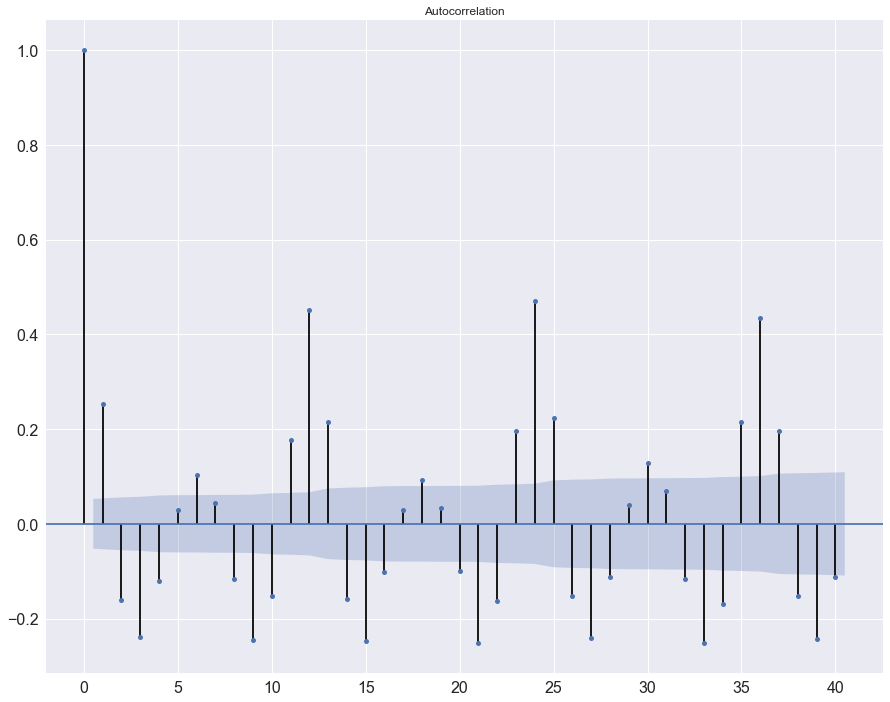

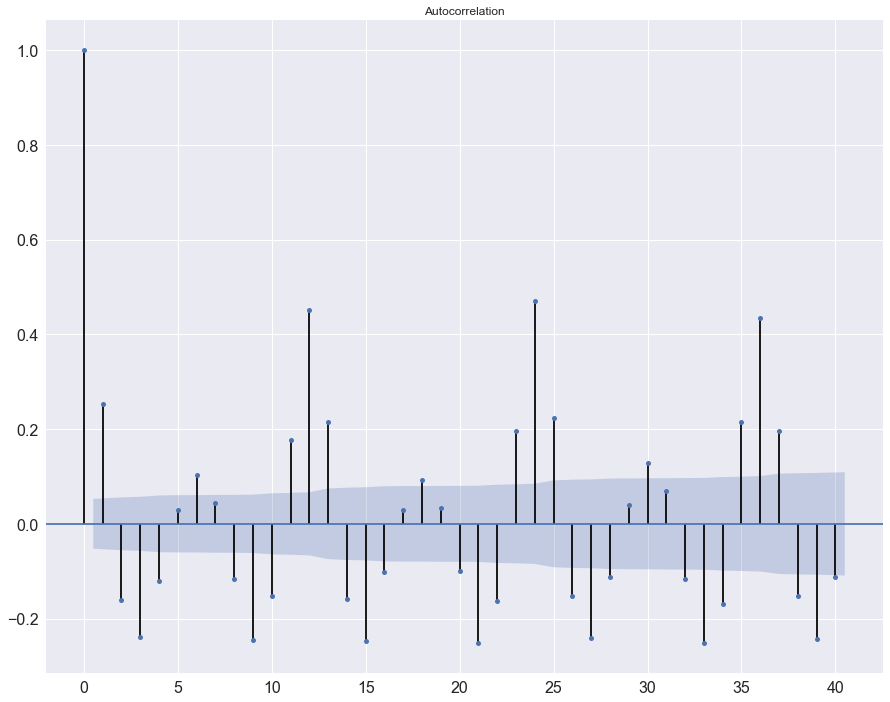

In [14]:
plot_acf(df['Rainfall'].values.squeeze(),lags=40)

## A lecsengést kellene figyelnünk ami esetünkben jól  megfigyelhető a parciális autokorrelációs korrelogrammon.

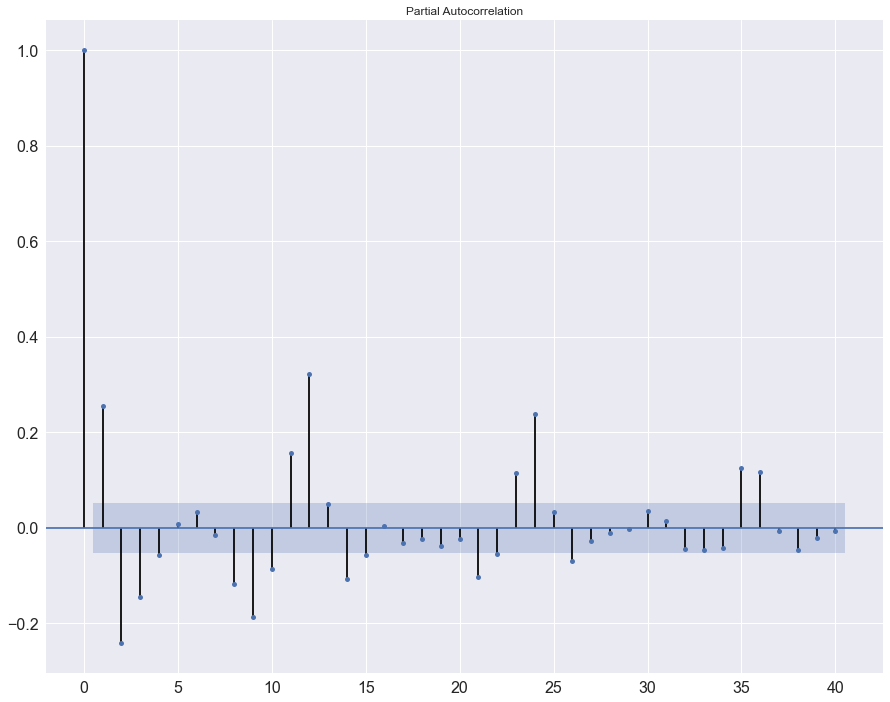

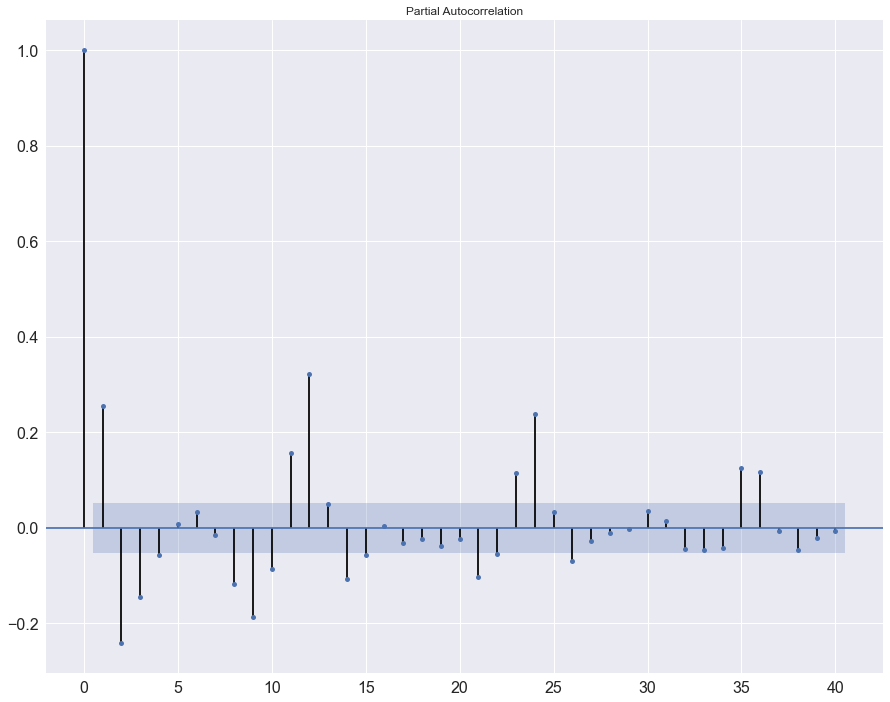

In [15]:
plot_pacf(df['Rainfall'].values.squeeze(),lags=40)

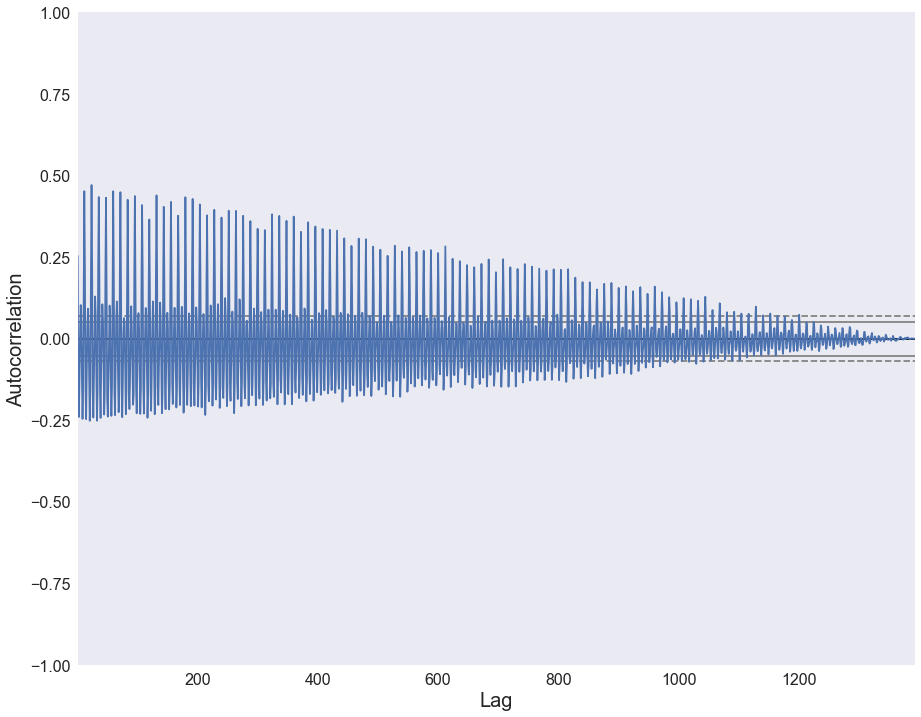

In [16]:
autocorrelation_plot(df['Rainfall'])

## Látható, hogy 1200 lag körül, már 0 körüli értéket vesz fel, tehát lecseng

In [17]:
autoarima_model = pmd.auto_arima(df['Rainfall'], 
                              start_p=1, 
                              start_q=1,
                              test="adf",
                              trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=12461.071, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=12588.947, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=12498.158, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=12460.889, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=13733.588, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=12457.764, Time=0.20 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=12413.035, Time=0.78 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=12218.505, Time=1.22 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=12386.744, Time=0.74 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=12390.252, Time=0.75 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=12165.668, Time=1.34 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=12393.480, Time=1.00 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.49 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=12399.440, Time=1.87 sec
 ARIMA(1,0,4)(0,0,0)[0] i

In [18]:
autoarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1392
Model:               SARIMAX(2, 0, 3)   Log Likelihood               -6075.834
Date:                Wed, 21 Apr 2021   AIC                          12165.668
Time:                        15:22:18   BIC                          12202.338
Sample:                             0   HQIC                         12179.380
                               - 1392                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     24.1791      0.937     25.804      0.000      22.343      26.016
ar.L1          0.9985      0.002    405.015      0.000       0.994       1.003
ar.L2         -0.9969      0.002   -449.666      0.000      -1.001      -0.993
ma.L1         -0.7935      0.026    -30.877      0.000      -0.844      -0.743
ma.L2          0.7988      0.025     31.955      0.000       0.750       0.848
ma.L3          0.1809      0.025      7.231      0.000       0.132       0.230
sigma2       372.2502     10.794     34.486      0.000     351.094     393.407
===================================================================================
Ljung-Box (Q):                      539.15   Jarque-Bera (JB):              2094.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             1.65
Prob(H) (two-sided):                  0.05   Kurtosis:                         8.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Látható, hogy a legjobb AIC érték a 12165.668 ami a 2,0,3 orderhez tartozó modellre igaz.

In [19]:
from sklearn.metrics import mean_squared_error

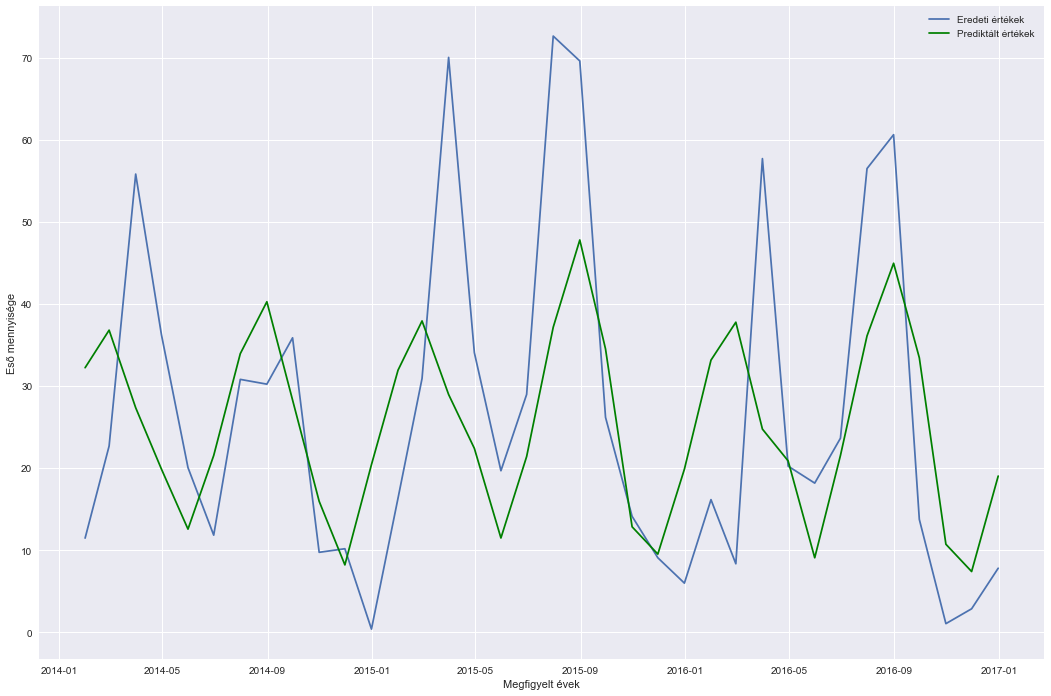

In [16]:
model = ARIMA(df['Rainfall'],order=(2,0,3),freq='M')
result = model.fit(disp=1)

plt.figure(figsize=(18,12))
plt.plot(df['Rainfall'][-36:])
plt.plot(result.fittedvalues[-36:],color='green')
plt.xlabel('Megfigyelt évek')
plt.ylabel('Eső mennyisége')
plt.legend(['Eredeti értékek','Prediktált értékek'])
plt.show()


In [17]:
arima_pred = result.predict(start = '1901-01-31', end = len(df)-1, typ="levels").rename("ARIMA Predictions")
df['ARIMA_Predictions'] = arima_pred

mse = mean_squared_error(df['Rainfall'],arima_pred)
from statsmodels.tools.eval_measures import rmse

In [18]:
print("Rainfall mean",df['Rainfall'].mean())
print("RMSE value:",rmse(df['Rainfall'],arima_pred))

Rainfall mean 25.142391681034493
RMSE value: 18.877195313270192


Esetünkben véleményem szerint, az rmse értéke a kiugró adatok mellett teljesen érthető, mivel az átlag is 25 körül van.

In [19]:
#Predikciós lehetőség 1
start_index = '2016-12-31'
end_index = '2020-03-31'
a = result.predict(start=start_index, end=end_index)

a

2016-12-31    19.043556
2017-01-31    33.637776
2017-02-28    41.035357
2017-03-31    30.386807
2017-04-30    14.498171
2017-05-31     9.253749
2017-06-30    19.896443
2017-07-31    35.786375
2017-08-31    41.037950
2017-09-30    30.401114
2017-10-31    14.509890
2017-11-30     9.251164
2017-12-31    19.882139
2018-01-31    35.774652
2018-02-28    41.040528
2018-03-31    30.415416
2018-04-30    14.521617
2018-05-31     9.248593
2018-06-30    19.867839
2018-07-31    35.762920
2018-08-31    41.043092
2018-09-30    30.429713
2018-10-31    14.533354
2018-11-30     9.246036
2018-12-31    19.853545
2019-01-31    35.751179
2019-02-28    41.045642
2019-03-31    30.444004
2019-04-30    14.545099
2019-05-31     9.243493
2019-06-30    19.839256
2019-07-31    35.739429
2019-08-31    41.048177
2019-09-30    30.458290
2019-10-31    14.556854
2019-11-30     9.240965
2019-12-31    19.824973
2020-01-31    35.727670
2020-02-29    41.050699
2020-03-31    30.472571
Freq: M, dtype: float64

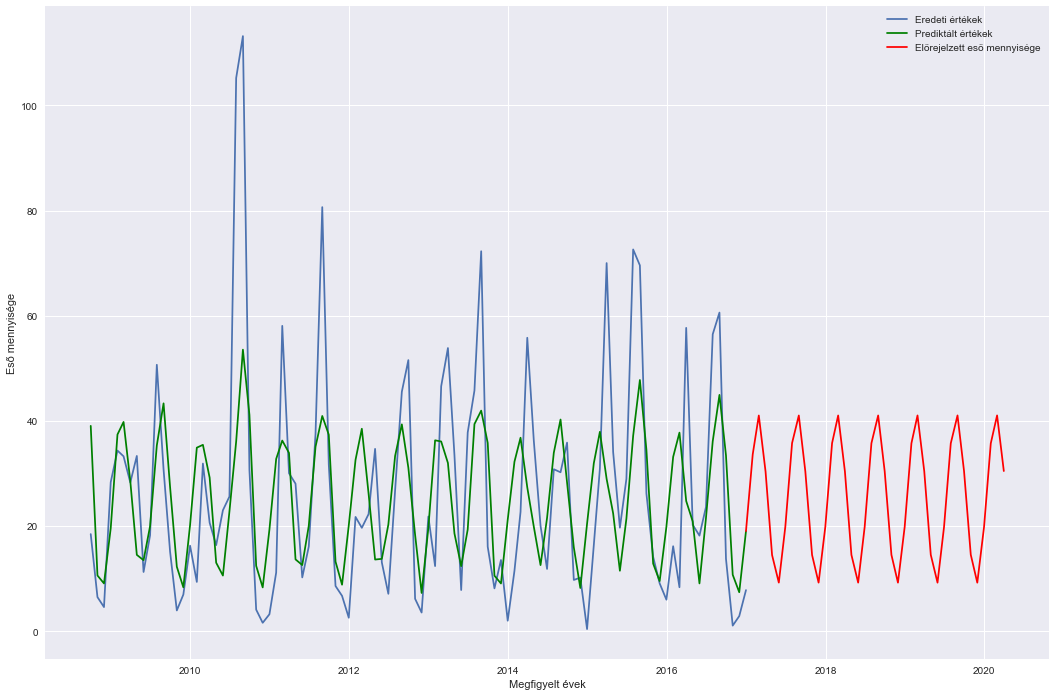

In [20]:
plt.figure(figsize=(18,12))
plt.plot(df['Rainfall'][-100:])
plt.plot(result.fittedvalues[-100:],color='green')
plt.plot(a,color='red')
plt.xlabel('Megfigyelt évek')
plt.ylabel('Eső mennyisége')
plt.legend(['Eredeti értékek','Prediktált értékek','Előrejelzett eső mennyisége'])
plt.show()


Látható, hogy minimális eltérés tapasztalható, az ábrán, bár ez az adatokon is látszott.

In [21]:
months = df.index.month

In [22]:
monthly_sum=df.groupby(months).sum()

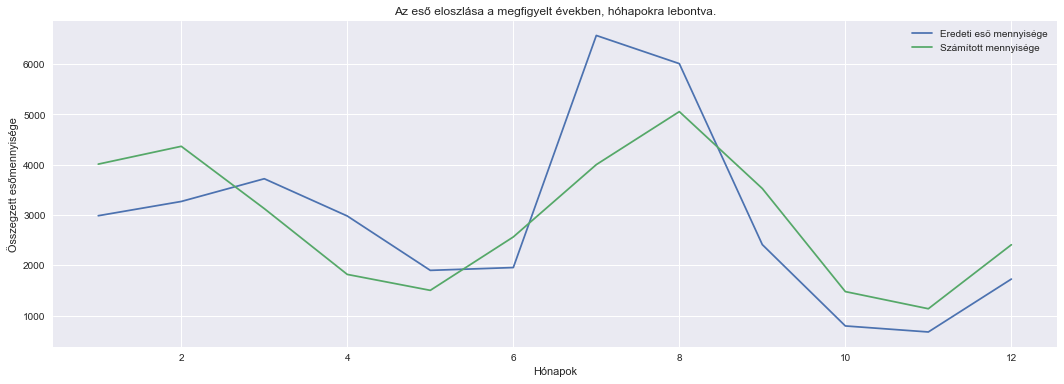

In [23]:
plt.figure(figsize=(18,6))
plt.plot(monthly_sum['Rainfall'])
plt.plot(monthly_sum['ARIMA_Predictions'])
plt.xlabel('Hónapok')
plt.ylabel('Összegzett esőmennyisége')
plt.legend(['Eredeti eső mennyisége','Számított mennyisége'])
plt.title('Az eső eloszlása a megfigyelt években, hóhapokra lebontva.')
plt.show()

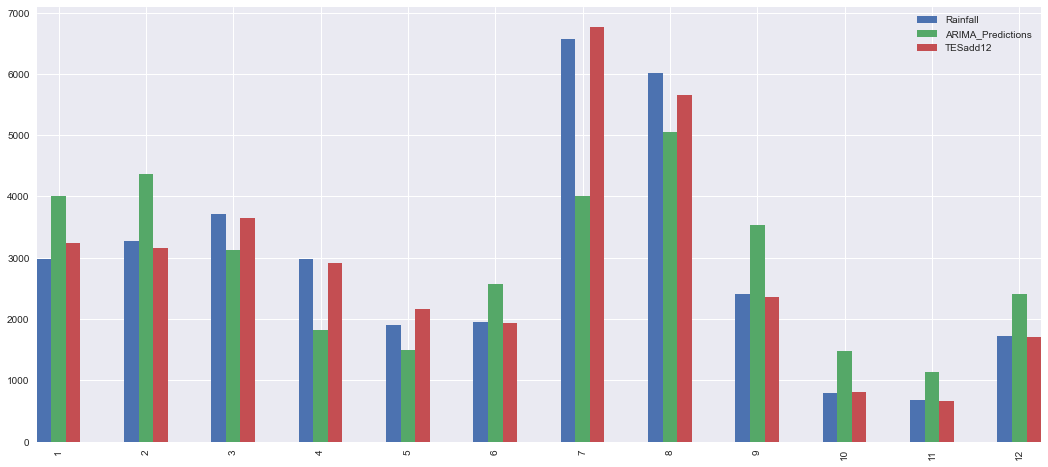

In [31]:
monthly_sum[['Rainfall','ARIMA_Predictions','TESadd12']].plot(figsize=(18,8),kind='bar').autoscale(axis='x',tight=True);

In [25]:
# Itt is látható a folyamatos csökkenés utánna pedig az emelkedés

In [32]:
b = df['Rainfall'].sum()
c = df['ARIMA_Predictions'].sum()
h = df['TESadd12'].sum()
print(b)
print(c)

e = abs(b-c)
g = abs(b-h)
print(e)
print(g)

34998.209220000004
34996.79038317852
1.4188368214818183
16.896017116116127
